# tension_time_evolution

> Evolve tension in time

Simulate time evolution of tension triangulation, so far without reference to real space. Ensure flatness at every step using fake energy minimization.

See lattice model simulation notebooks.

In [ ]:
#| default_exp tension

In [ ]:
#| hide
from nbdev.showdoc import *
import nbdev

In [ ]:
from CE_simulation.triangle import *

In [ ]:
#| export
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from numpy import sin, cos, tan, pi, sqrt, arccos, arctan, arctan2
from numpy.linalg import norm

from scipy.integrate import solve_ivp
from scipy import ndimage
from scipy import spatial
from scipy import optimize

from tqdm.notebook import tqdm

import sys

In [ ]:
#| export

from dataclasses import dataclass
from typing import Union, Dict, List, Tuple, Iterable
from nptyping import NDArray, Int, Float, Shape

from fastcore.foundation import patch

## Time evolution in a single triangle

In [ ]:
#| export

# basic formulas for triangles

def vectors_angle(a,b):
    """Angle between two vectors"""
    inner = (a@b)/sqrt((a@a)*(b@b))
    return arccos(inner)

def sides_area(Ts):
    """Triangle area from side lengths"""
    Ts = np.sort(Ts, axis=0)[::-1]
    #A = sqrt((Ts[0]+Ts[1]+Ts[2])*(-Ts[0]+Ts[1]+Ts[2])*(Ts[0]-Ts[1]+Ts[2])*(Ts[0]+Ts[1]-Ts[2]))/4
    A = (Ts[0]+(Ts[1]+Ts[2]))*(Ts[2]-(Ts[0]-Ts[1]))*(Ts[2]+(Ts[0]-Ts[1]))*(Ts[0]+(Ts[1]-Ts[2]))/16
    return sqrt(np.clip(A, 0, np.inf))

def sides_circum(Ts):
    """Triangle circumcircle from side lengths"""
    R = np.prod(Ts, axis=0)/(4*sides_area(Ts))
    return R

def sides_angles(Ts):
    """Triangle angles from side lengths. Sorted so that angle [i] is opposite to Ts[i]"""
    R = sides_circum(Ts)
    inds = np.argmax(Ts, axis=0)
    # need to take the smaller two angles so as to avoid error in arcsin for angles >90
    phis = np.arcsin(Ts/(2*R))
    if isinstance(inds, np.ndarray):
        phis[inds, np.arange(len(inds))] = pi-(phis.sum(axis=0)-phis[inds, np.arange(len(inds))])
    else:
        phis[inds] =  pi-(phis.sum(axis=0)-phis[inds])
    return phis

def angles_shape(phis):
    """Shape order parameter from angles"""
    alpha, beta, gamma = phis
    x = sqrt(3)*sin(alpha)*sin(alpha+2*beta)
    y = (cos(alpha)*cos(alpha+2*beta) - cos(2*alpha))
    psi = np.arctan2(x, y) + pi

    Psi = 6+2*(cos(4*triangle)-cos(2*triangle) - cos(2*(triangle-np.roll(triangle, 1, axis=0)))).sum(axis=0)
    Psi /= (3-cos(2*triangle).sum(axis=0))**2
    Psi = np.sqrt(Psi)
    
    psi_tilde = pi - np.abs((3*psi) % (2*pi) - pi)
    
    return np.array([psi_tilde, Psi])

In [ ]:
round(sides_area([1, 1, sqrt(2)]), ndigits=3) == 1/2

True

In [ ]:
round(sides_circum([sqrt(3), sqrt(3), sqrt(3)]), ndigits=3) == 1

True

In [ ]:
np.round(sides_angles(np.array([1, 1, 1]))*180/pi) == 60

array([ True,  True,  True])

In [ ]:
#| export
def sides_area_jac(Ts):
    """get jacobian of area change in edge length"""
    dA = np.array([0., 0., 0.])
    #inds = np.argsort(-Ts, axis=0)
    #Ts = np.take_along_axis(Ts, inds, axis=0)
    dA += np.array([1, 1, 1])   * (Ts[2]-(Ts[0]-Ts[1])) * (Ts[2]+(Ts[0]-Ts[1])) * (Ts[0]+(Ts[1]-Ts[2]))
    dA += (Ts[0]+(Ts[1]+Ts[2])) * np.array([-1, 1, 1])  * (Ts[2]+(Ts[0]-Ts[1])) * (Ts[0]+(Ts[1]-Ts[2]))
    dA += (Ts[0]+(Ts[1]+Ts[2])) * (Ts[2]-(Ts[0]-Ts[1])) * np.array([1, -1, 1])  * (Ts[0]+(Ts[1]-Ts[2]))
    dA += (Ts[0]+(Ts[1]+Ts[2])) * (Ts[2]-(Ts[0]-Ts[1])) * (Ts[2]+(Ts[0]-Ts[1])) * np.array([1, 1, -1])

    dA /= 48*(sides_area(Ts)+1e-5)
    #dA = np.take_along_axis(dA, inds, axis=0)
    return dA

In [ ]:
Ts = np.array([.7, 1.3, sqrt(2)])
dTs = np.array([.2, -.2, -.05])

areas = [round(x, ndigits=2)
         for x in [sides_area(Ts), sides_area(Ts+dTs), sides_area(Ts)+sides_area_jac(Ts).dot(dTs)]]

print(areas)
assert areas[1] == areas[2]  # to reasonable precision

[0.45, 0.49, 0.49]


In [ ]:
#| export

# tension time evolution in triangle with constrained area
def excitable_dt(Ts, m=2):
    """Time derivative of tensions under excitable tension model with constrained area"""
    dT_dt = Ts**m
    area_jac = sides_area_jac(Ts)
    area_jac /= norm(area_jac)
    dT_dt -= area_jac * (area_jac@dT_dt)
    return dT_dt

def excitable_dt_perim(Ts, m=2):
    """Time derivative of tensions under excitable tension model with constrained perimeter"""
    dT_dt = Ts**m
    dT_dt -= dT_dt.sum()
    return dT_dt

In [ ]:
Ts = np.array([.7, 1.3, sqrt(2)])
dt = .02
dTs = excitable_dt(Ts) * dt

areas = [round(x, ndigits=2) for x in [sides_area(Ts), sides_area(Ts+dTs)]]
print(areas)
assert areas[0] == areas[1]  # to reasonable precision, areas don't change

[0.45, 0.45]


In [ ]:
#| export
def excitable_dt_angles(phi_is, m=2):
    """Time derivative of angles under excitable tension model with constrained circumcircle"""
    # convert to angles
    Ti_rate = sin(phi_is)**(m-1)
    second_term = (Ti_rate * tan(phi_is)).sum() / tan(phi_is).sum()
    phi_is_dot = tan(phi_is) * (Ti_rate  - second_term)
    return phi_is_dot

## To Do:

- add `rest` (length) and `flipped` attributes to the `HalfEdge` class -> Done
- remove Edge class? Not really required if we simulate based on half edges -> Done
- add method to compute lengths, angles of `HalfEdges` in `HalfEdgeMesh` -> Done

## ODE integrator

Need to make my own little ODE solver because between ODE steps, we will need to find the real space tessellation. 

Se Numerical Recipes Chpt. 17. 

In [ ]:
## scipy ODE solver for some triangle

y0 = np.array([sqrt(2), 1.2, 1])
A0 = sides_area(y0)

rhs = lambda t, y: excitable_dt(y, m=2)

t = np.linspace(0, .7, 100)

sol = solve_ivp(rhs, (t[0], t[-1]), y0,  t_eval=t, method="RK45", rtol=1e-4,)
print(sol["message"])
sol = sol["y"]
As = sides_area(sol)
angles = sides_angles(sol) * (180/pi)

# eventually unstable as angles become very small

The solver successfully reached the end of the integration interval.


(0.0, 2.0)

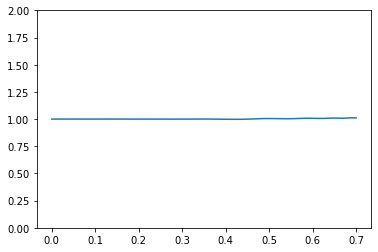

In [ ]:
plt.plot(t, As/A0)
plt.ylim([0, 2])

[<matplotlib.lines.Line2D>]

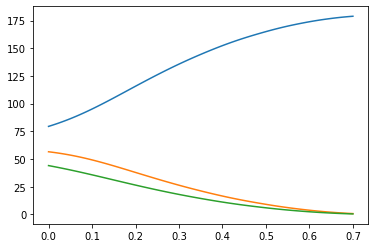

In [ ]:
plt.plot(t, angles[0])
plt.plot(t, angles[1])
plt.plot(t, angles[2])

[<matplotlib.lines.Line2D>]

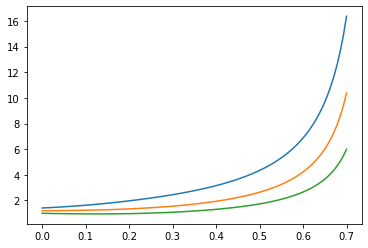

In [ ]:
plt.plot(t, sol[0])
plt.plot(t, sol[1])
plt.plot(t, sol[2])

In [ ]:
## naive Euler stepping - looks ok!

Ts = [y0,]
ts = [0,]

dt = .01

for i in range(70):
    ts.append(ts[-1]+dt)
    T_new = Ts[-1]+dt*excitable_dt(Ts[-1], m=2)
    Ts.append(T_new)
Ts = np.stack(Ts, axis=-1)
ts = np.array(ts)

[<matplotlib.lines.Line2D>]

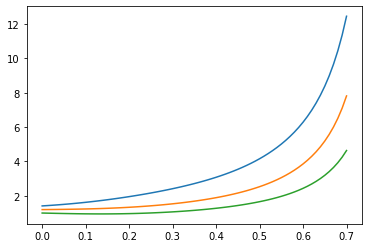

In [ ]:
plt.plot(ts, Ts[0])
plt.plot(ts, Ts[1])
plt.plot(ts, Ts[2])

## Create a test Half edge mesh and add a method to calculate internal angles

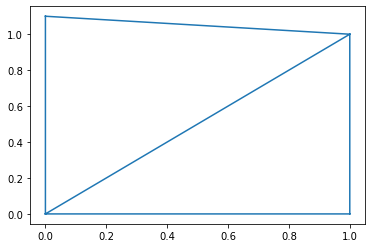

In [ ]:
test_hemesh = get_test_hemesh()

test_hemesh.triplot()

In [ ]:
#|export
@patch

def get_angles(self: HalfEdgeMesh):
    angle_dict = {}
    egde_lengths = {key: norm(val) for key, val in self.get_edge_vecs().items()}
    for fc in self.faces.values():
        lengths = []
        heids = []
        returned = False
        start_he = fc.hes[0]
        he = start_he
        while not returned:
            heids.append(he._heid)
            lengths.append(egde_lengths[he._heid])
            he = he.nxt
            returned = (he == start_he)
        angles = sides_angles(lengths) 
        for heid, a in zip(heids, angles):
            angle_dict[heid] = a   
    return angle_dict

In [ ]:
test_hemesh.get_angles()

{0: 0.7853981633974482,
 1: 0.7853981633974482,
 2: 1.5707963267948966,
 3: 1.4711276743037347,
 4: 0.7853981633974481,
 5: 0.8850668158886102}

## Optimize vertex positions given rest lengths

In [ ]:
## define function to measure energy = sum_edges (l_e -l_e,0)^2
# needs to take in a vector of vertex positions of shape (n)

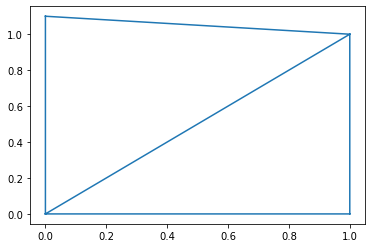

In [ ]:
mesh = get_test_hemesh()
mesh.triplot()

In [ ]:
# create a test vector

for he in mesh.hes.values():
    he.rest = 1.5 # for testing purposes

In [ ]:
# step 0: prepare initial condition. will serve as test vector. sort vectors by keys.

vertex_keys = sorted(mesh.vertices.keys())
vertex_vector = np.stack([mesh.vertices[key].coords for key in vertex_keys]).T

# scipy otpmize needs a 1d array. so stack x coords on top of y coords
x0 = np.hstack([vertex_vector[0], vertex_vector[1]])

In [ ]:
#%%time

# step 1: create a list of initial & terminal edge vertices. this will be used to calculate differences
# also create a reference vector of 

e_lst = []
rest_lengths = []

# we will need to look up which vertex key corresponds to list position
vertex_key_dict = {key: ix for ix, key in enumerate(sorted(mesh.vertices.keys()))}

for e in mesh.hes.values():
    if e._verticesid[0] < e._verticesid[1]: # avoid duplicates
        e_lst.append([vertex_key_dict[v._vid] for v in e.vertices])
        rest_lengths.append((e.rest+e.twin.rest)/2)
        
e_lst = np.array(e_lst).T
rest_lengths = np.array(rest_lengths)

# step 2 split up the vector and calculate lengths

x, y = (x0[:int(len(x0)/2)], x0[int(len(x0)/2):])
print((x[e_lst[0]]-x[e_lst[1]]), (y[e_lst[0]]-y[e_lst[1]]))  # looks good
lengths = sqrt((x[e_lst[0]]-x[e_lst[1]])**2 + (y[e_lst[0]]-y[e_lst[1]])**2)

E = 1/2 * (lengths-rest_lengths)**2

# it is much much faster to create these structures once only. 

[-1.  0. -1. -1.  0.] [ 0.  -1.  -1.   0.1 -1.1]


## To Do:

We can add additional area and/or perimeter energies for each triangle. Both can be calculated from the length, though in the case of the area the jacobian is likely ugly

In [ ]:
#| export

import autograd.numpy as anp  # Thinly-wrapped numpy
from autograd import grad as agrad

from scipy.sparse import csc_matrix

In [ ]:
#| export

@patch
def vertices_to_initial_cond(self: HalfEdgeMesh):
    """Format vertices for use in energy minimization."""
    vertex_keys = sorted(self.vertices.keys())
    vertex_vector = np.stack([self.vertices[key].coords for key in vertex_keys]).T
    return np.hstack([vertex_vector[0], vertex_vector[1]])
       
@patch
def initial_cond_to_vertices(self: HalfEdgeMesh, x0):
    """Reverse of format vertices for use in energy minimization."""
    vertex_keys = sorted(self.vertices.keys())
    x, y = (x0[:int(len(x0)/2)], x0[int(len(x0)/2):])
    vertex_vector = np.stack([x, y], axis=1)
    return {key: val for key, val in zip(vertex_keys, vertex_vector)}

@patch
def get_energy_fct(self: HalfEdgeMesh):
    """Get energy function sum_edges (l_e -l_e,0)^2. remove translation mode by keeping COM fixed."""
    e_lst = []
    rest_lengths = []

    # we will need to look up which vertex key corresponds to list position
    vertex_key_dict = {key: ix for ix, key in enumerate(sorted(self.vertices.keys()))}
    for e in self.hes.values():
        if e.duplicate: # avoid duplicates
            e_lst.append([vertex_key_dict[v._vid] for v in e.vertices])
            rest_lengths.append((e.rest+e.twin.rest)/2)

    e_lst = anp.array(e_lst).T
    rest_lengths = anp.array(rest_lengths)
    center = anp.mean([val.coords for val in self.vertices.values()], axis=0)
    n_vertices = len(self.vertices)
    def get_E(x0):
        x, y = (x0[:n_vertices], x0[n_vertices:])
        lengths = anp.sqrt((x[e_lst[0]]
                            #vertex_into_edge.dot(x)
                            -x[e_lst[1]])**2
                           + (y[e_lst[0]]-y[e_lst[1]])**2)
        E = 1/2 * anp.sum((lengths-rest_lengths)**2)
        # displacement from initial center
        E = E + 1/2*((anp.mean(x)-center[0])**2+(anp.mean(y)-center[0]))**2
        return E
    
    return get_E, agrad(get_E)

In [ ]:
test_hemesh_large = get_test_hemesh_large()

x0 = test_hemesh_large.vertices_to_initial_cond()
get_E, jac = test_hemesh_large.get_energy_fct()

In [ ]:
%%timeit

get_E(x0)
# pretty fast.

66 µs ± 1.85 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
%%timeit

jac(x0)
# autograd: 3ms

2.59 ms ± 162 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
test_hemesh = get_test_hemesh()

for he in test_hemesh.hes.values():
    he.rest = 1.5 # for testing purposes

In [ ]:
print(test_hemesh.initial_cond_to_vertices(test_hemesh.vertices_to_initial_cond()))
print({key: val.coords for key, val in test_hemesh.vertices.items()})
# looks good

{0: array([0., 0.]), 1: array([0. , 1.1]), 2: array([1., 0.]), 3: array([1., 1.])}
{0: array([0., 0.]), 1: array([0. , 1.1]), 2: array([1., 0.]), 3: array([1., 1.])}


## now let's try to minimize!

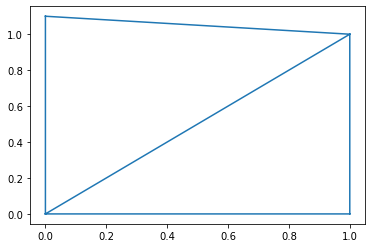

In [ ]:
# create a test case

mesh = get_test_hemesh()
for he in mesh.hes.values():
    he.rest = 1.5 # for testing purposes
mesh.triplot()

In [ ]:
%%time
x0 = mesh.vertices_to_initial_cond()
get_E, grd = mesh.get_energy_fct()

sol = optimize.minimize(get_E, x0, method="BFGS", jac=agrad(get_E))

print(sol["message"])
new_coord_dict = mesh.initial_cond_to_vertices(sol["x"])
for key, val in mesh.vertices.items():
    val.coords = new_coord_dict[key]

Optimization terminated successfully.
CPU times: user 21.7 ms, sys: 186 µs, total: 21.9 ms
Wall time: 20.9 ms


In [ ]:
mesh.get_edge_lens()

{0: 1.499999631183294,
 6: 1.499999631183294,
 1: 1.5000018566183846,
 7: 1.5000018566183846,
 2: 1.500000383127206,
 3: 1.500000383127206,
 4: 1.499998168706112,
 8: 1.499998168706112,
 5: 1.5000003669494066,
 9: 1.5000003669494066}

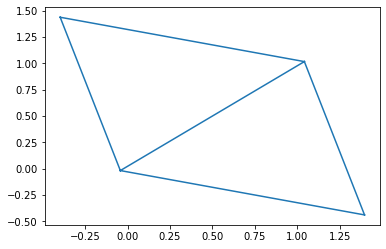

In [ ]:
mesh.triplot()

### Try a larger mesh

In [ ]:
#| export
@patch
def pre_optimize(self: HalfEdgeMesh, fact=.3, n_iter=1):
    """Greedy pre-optimization"""
    for i in range(n_iter):
        for he in self.hes.values():
            if he.duplicate:
                rest = (he.rest+he.twin.rest)/2
                vec = he.vertices[1].coords-he.vertices[0].coords
                length = norm(vec)
                delta = fact* vec/length * (length-rest)
                he.vertices[0].coords += delta/2
                he.vertices[1].coords -= delta/2
                
# for reasons which are fucking beyong me, as a patched class method this is very slow??

In [ ]:
# try a more difficult task - larger mesh

test_hemesh_large = get_test_hemesh_large()

edge_lengths = test_hemesh_large.get_edge_lens()
for e, val in edge_lengths.items():
    test_hemesh_large.hes[e].rest = val + np.random.normal(scale=1e-2)
    #mesh.hes[e].rest = 1.01*val

In [ ]:
%%time

# pre-optimizing improves energy by 2x in 250ms

get_E, grd = test_hemesh_large.get_energy_fct()
x0 = test_hemesh_large.vertices_to_initial_cond()
print(get_E(x0))

test_hemesh_large.pre_optimize(fact=.3, n_iter=2)

x0 = test_hemesh_large.vertices_to_initial_cond()
print(get_E(x0))

0.09034822215769824
0.04446955179893808
CPU times: user 293 ms, sys: 0 ns, total: 293 ms
Wall time: 290 ms


In [ ]:
# how fast is optimization with scipy?

test_hemesh_large = get_test_hemesh_large()

edge_lengths = test_hemesh_large.get_edge_lens()
for e, val in edge_lengths.items():
    test_hemesh_large.hes[e].rest = val + np.random.normal(scale=1e-3)
    #mesh.hes[e].rest = 1.01*val
get_E, grd = test_hemesh_large.get_energy_fct()
x0 = test_hemesh_large.vertices_to_initial_cond()
get_E(x0)

0.0009034867707847972

In [ ]:
%%time
sol = optimize.minimize(get_E, x0, method="BFGS", jac=grd, tol=1e-3)
print(sol["message"])
get_E(x0) / get_E(sol["x"])

Optimization terminated successfully.
CPU times: user 5.8 s, sys: 860 ms, total: 6.66 s
Wall time: 1.91 s


3.0202882747151483

In [ ]:
%%time
sol = optimize.minimize(get_E, x0, method="BFGS", jac=grd, tol=1e-3)
print(sol["message"])
get_E(x0) / get_E(sol["x"])

# without the gradient

Optimization terminated successfully.
CPU times: user 5.57 s, sys: 764 ms, total: 6.33 s
Wall time: 1.78 s


3.0202882747151483

In [ ]:
# now compare otimization and pre-optimization in terms of speed

test_hemesh_large = get_test_hemesh_large()

edge_lengths = test_hemesh_large.get_edge_lens()
for e, val in edge_lengths.items():
    test_hemesh_large.hes[e].rest = val + np.random.normal(scale=1e-3)
    #mesh.hes[e].rest = 1.01*val
get_E, grd = test_hemesh_large.get_energy_fct()
x00 = test_hemesh_large.vertices_to_initial_cond()
print(get_E(x00))

test_hemesh_large.pre_optimize(fact=.3, n_iter=2)

x0 = test_hemesh_large.vertices_to_initial_cond()
print(get_E(x00) / get_E(x0))

0.0009034867707847972
2.042174280462166


In [ ]:
%%time
sol = optimize.minimize(get_E, x0, method="BFGS", jac=grd, tol=1e-3)
print(sol["message"])
get_E(x00) / get_E(sol["x"])

Optimization terminated successfully.
CPU times: user 5.47 s, sys: 592 ms, total: 6.06 s
Wall time: 1.65 s


3.155840450054693

In [ ]:
## finally, this is how you re-set the coordinate values

new_coord_dict = mesh.initial_cond_to_vertices(sol["x"])
for key, val in mesh.vertices.items():
    val.coords = new_coord_dict[key]

## Euler step for whole triangulation

In [ ]:
mesh = get_test_hemesh()
mesh.set_rest_lengths()

[val.hes for val in mesh.faces.values()]

[[HalfEdge(_heid=0, _nxtid=1, _previd=2, _twinid=6, _faceid=0, _verticesid=(0, 2), rest=1.0, passive=0.0, flipped=0, duplicate=True),
  HalfEdge(_heid=1, _nxtid=2, _previd=0, _twinid=7, _faceid=0, _verticesid=(2, 3), rest=1.0, passive=0.0, flipped=0, duplicate=True),
  HalfEdge(_heid=2, _nxtid=0, _previd=1, _twinid=3, _faceid=0, _verticesid=(3, 0), rest=1.4142135623730951, passive=0.0, flipped=0, duplicate=False)],
 [HalfEdge(_heid=3, _nxtid=4, _previd=5, _twinid=2, _faceid=1, _verticesid=(0, 3), rest=1.4142135623730951, passive=0.0, flipped=0, duplicate=True),
  HalfEdge(_heid=4, _nxtid=5, _previd=3, _twinid=8, _faceid=1, _verticesid=(3, 1), rest=1.004987562112089, passive=0.0, flipped=0, duplicate=False),
  HalfEdge(_heid=5, _nxtid=3, _previd=4, _twinid=9, _faceid=1, _verticesid=(1, 0), rest=1.1, passive=0.0, flipped=0, duplicate=False)]]

In [ ]:
%%time

# using the fact that the list of faces in a mesh should now be correctly oriented, let's Euler step 
# all the rest lengths of a mesh (as long as they are not None)

m = 2
dt = .01

for fc in mesh.faces.values():
    # collect edges
    Ts = np.array([he.rest for he in fc.hes])
    Ts += dt*excitable_dt(Ts, m=2)
    for T, he in zip(Ts, fc.hes):
        he.rest = T

CPU times: user 1.42 ms, sys: 85 µs, total: 1.5 ms
Wall time: 1.13 ms


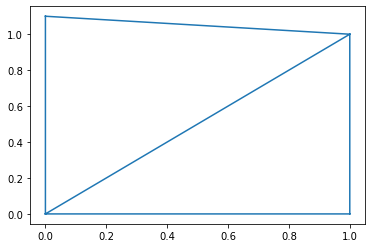

In [ ]:
mesh = get_test_hemesh()
mesh.set_rest_lengths()
mesh.triplot()

In [ ]:
%%time

# now let"s try a full loop with optimization

m = 2
dt = .01

for i in range(25):
    # euler step
    mesh.set_rest_lengths()
    for fc in mesh.faces.values():
        # collect edges
        Ts = np.array([he.rest for he in fc.hes])
        Ts += dt*excitable_dt(Ts, m=2)
        for T, he in zip(Ts, fc.hes):
            he.rest = T
    # flatten
    mesh.pre_optimize(fact=.3, n_iter=2)
    get_E, grd = mesh.get_energy_fct()
    x0 = mesh.vertices_to_initial_cond()
    sol = optimize.minimize(get_E, x0, method="BFGS", jac=grd, tol=1e-3)
    if sol["status"] !=0:
        print(sol["message"])
        break
    new_coord_dict = mesh.initial_cond_to_vertices(sol["x"])
    for key, val in mesh.vertices.items():
        val.coords = new_coord_dict[key]
    mesh.set_rest_lengths()

CPU times: user 182 ms, sys: 3.35 ms, total: 186 ms
Wall time: 185 ms


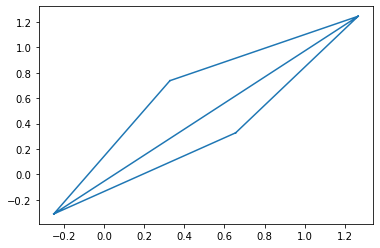

In [ ]:
mesh.triplot()

(-0.35000000000000003, 7.35, -0.35000000000000003, 7.35)

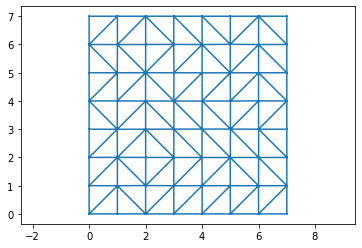

In [ ]:
## and now with a larger mesh

mesh = get_test_hemesh_large(x=np.arange(8.), y=np.arange(8.))
mesh.set_rest_lengths()
mesh.is_consistent()

mesh.triplot()
plt.axis("equal")

In [ ]:
%%time

# now let"s try a full loop with optimization

m = 2
dt = .01

for i in range(20):
    mesh.set_rest_lengths()
    # euler step
    for fc in mesh.faces.values():
        # collect edges
        Ts = np.array([he.rest for he in fc.hes])
        Ts += dt*excitable_dt(Ts, m=2)
        for T, he in zip(Ts, fc.hes):
            he.rest = T
    # flatten
    #pre_optimize(mesh, fact=.3, n_iter=2)
    get_E, grd = mesh.get_energy_fct()
    x0 = mesh.vertices_to_initial_cond()
    sol = optimize.minimize(get_E, x0, method="BFGS", jac=grd, tol=1e-3)
    if sol["status"] !=0:
        print(sol["message"])
        break
    new_coord_dict = mesh.initial_cond_to_vertices(sol["x"])
    for key, val in mesh.vertices.items():
        val.coords = new_coord_dict[key]
    mesh.set_rest_lengths()
        

CPU times: user 2.55 s, sys: 1.61 s, total: 4.16 s
Wall time: 1.19 s


(-0.9949872871750753,
 8.245620583432487,
 -0.9351876951144402,
 7.9897080942736975)

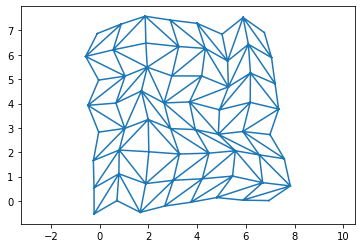

In [ ]:
mesh.triplot()
plt.axis("equal")

## Simulation with edge flips

In [ ]:
#| export
from copy import deepcopy

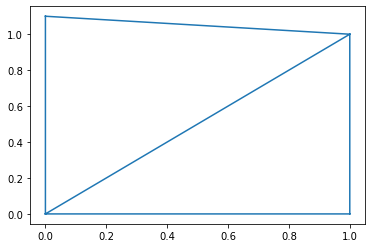

In [ ]:
mesh = get_test_hemesh()

mesh.set_rest_lengths()
mesh.triplot()

flip


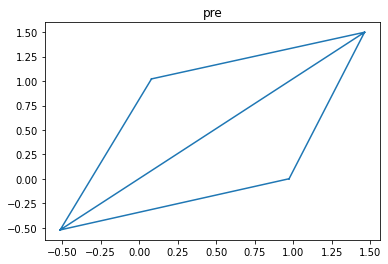

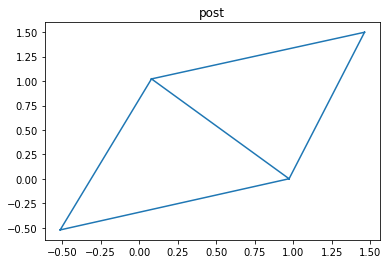

CPU times: user 2.52 s, sys: 191 ms, total: 2.71 s
Wall time: 2.31 s


In [ ]:
%%time

# now let"s try a full loop with optimization

m = 2
dt = .001

meshes = [mesh]
times = [0]

for i in range(600):
    # euler step
    for fc in mesh.faces.values():
        # collect edges
        Ts = np.array([he.rest for he in fc.hes])
        Ts += dt*excitable_dt(Ts, m=2)
        for T, he in zip(Ts, fc.hes):
            he.rest = T
    # flatten
    mesh.pre_optimize(fact=.3, n_iter=2)
    get_E, grd = mesh.get_energy_fct()
    x0 = mesh.vertices_to_initial_cond()
    sol = optimize.minimize(get_E, x0, method="BFGS", jac=grd, tol=1e-3)
    if sol["status"] !=0:
        print(sol["message"])
        break
    new_coord_dict = mesh.initial_cond_to_vertices(sol["x"])
    for key, val in mesh.vertices.items():
        val.coords = new_coord_dict[key]
    mesh.set_rest_lengths()
    # compute angles and carry out an edge flip if required
    angles = mesh.get_angles()
    argmax = max(angles, key=angles.get)
    if angles[argmax] > 130 * (pi/180):
        print("flip")
        mesh.triplot()
        plt.title("pre")
        plt.show()
        
        mesh.flip_edge(argmax)
        mesh.set_rest_lengths()

        mesh.triplot()
        plt.title("post")
        plt.show()

    meshes.append(deepcopy(mesh))
    times.append(times[-1]+dt)

In [ ]:
## code for handling "passive" tension post 

## Add code to compute relative tensions

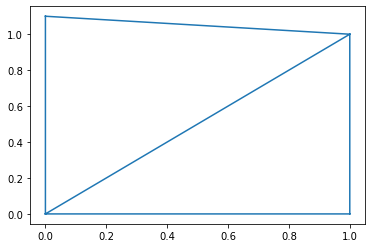

In [ ]:
mesh = get_test_hemesh()
mesh.set_rest_lengths()

mesh.triplot()

In [ ]:
@patch
def get_rel_tension(self: HalfEdgeMesh):
    rel_tensions = {}
    for he in self.hes.values():
        surrounding = []
        if he._heid < he.twin and he.face is not None:
            surrounding.append(self.hes[he.nxt].rest)
            surrounding.append(self.hes[he.prev].rest)
            twin = self.hes[he.twin]
            surrounding.append(self.hes[twin.nxt].rest)
            surrounding.append(self.hes[twin.prev].rest)
            rel_tensions[he._heid], rel_tensions[he.twin] = 2*(4*he.rest/sum(surrounding),)
    return rel_tensions

In [ ]:
mesh.get_rel_tension()

{0: 0.8860901117618422,
 6: 0.8860901117618422,
 1: 0.905140971710352,
 7: 0.905140971710352,
 2: 1.3780441874425138,
 3: 1.3780441874425138,
 4: 0.8712102710696579,
 8: 0.8712102710696579,
 5: 0.9945326277175857,
 9: 0.9945326277175857}

## Mesh plot with colored edges

In [ ]:
def triplot(self: HalfEdgeMesh):
    """wraps plt.triplot, unfortunately only faces can be colored"""
    list_format = self.to_ListOfVerticesAndFaces()
    fcs = np.array(list(list_format.faces.values()))
    pts = np.array(list(list_format.vertices.values())).T
    plt.triplot(pts[0], pts[1], fcs)

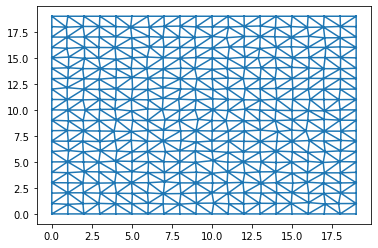

In [ ]:
mesh = get_test_hemesh_large(x=np.arange(20.), y=np.arange(20.))
mesh.set_rest_lengths()
mesh.triplot()

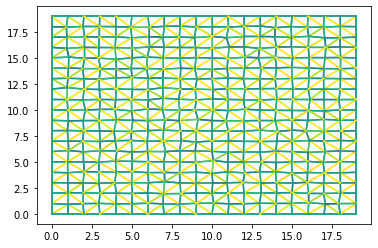

In [ ]:
vmin, vmax = (.5, 1.4)
rescale = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap =  mpl.colormaps['viridis']

color_by = mesh.get_edge_lens()

for key, he in mesh.hes.items():
    line = np.stack([mesh.vertices[he.vertices[0]].coords, mesh.vertices[he.vertices[1]].coords])
    plt.plot(*line.T, c=cmap(rescale(color_by[key])))


## Export code

In [ ]:
#| hide
nbdev.nbdev_export()

## Old, abandoned code